In [1]:
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
import shapely
import os
import pandas as pd
import pycountry
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [2]:
# clean 
def iso3_to_country_name(iso3_code):
    try:
        country = pycountry.countries.get(alpha_2=iso3_code)
        if country:
            return country.name
        else:
            return "Country not found"
    except AttributeError:
        return "Country not found"



# Create a subfolder if it doesn't exist
dir_path = "EGM_2019_SHP_20190312/DATA/Countries"
files = os.listdir(dir_path)
countries_string = (sorted(files))[1:] + ['EU']
print(countries_string)
subfolder_path = 'output'
os.makedirs(subfolder_path, exist_ok=True)



#for name in countries_string[:]:
for name in countries_string:
    empty_geometry = pd.DataFrame()
    empty_geometry['geometry'] = 'nan'
    empty_geometry['ICC'] = 'nan'

    nodes_return = pd.DataFrame()
    edges_return = pd.DataFrame()

    base_path = 'EGM_2019_SHP_20190312/DATA/Countries/' + name + '/'

    if name == 'EU':
        base_path = 'EGM_2019_SHP_20190312/DATA/FullEurope/'


    # Chapter 1: pulling the files

    rails_path = base_path + 'RailrdL.shp'
    stations_path = base_path + 'RailrdC.shp'
    country_code_path = base_path + 'CountryCodes.dbf'
    levelcc_path = base_path + 'LevelcC.shp'
    aircc_path = base_path + 'AirfldP.shp'
    ferrycc_path = base_path + 'FerryC.shp'

    
    if os.path.exists(rails_path):
        rails = gpd.read_file(rails_path)
        print(f'Loaded {rails_path}')
    
        
        if os.path.exists(stations_path):
            stations = gpd.read_file(stations_path)
            print(f'Loaded {stations_path}')
        else:
            stations = empty_geometry.copy()
        
        if os.path.exists(country_code_path):
            country_code = gpd.read_file(country_code_path)
            print(f'Loaded {country_code_path}')
        else:
            country_code = empty_geometry.copy()
        
        if os.path.exists(levelcc_path):
            levelcc = gpd.read_file(levelcc_path)
            print(f'Loaded {levelcc_path}')
        else:
            levelcc = empty_geometry.copy()
        
        if os.path.exists(aircc_path):
            aircc = gpd.read_file(aircc_path)
            print(f'Loaded {aircc_path}')
        else:
            aircc = empty_geometry.copy()
        
        if os.path.exists(ferrycc_path):
            ferrycc = gpd.read_file(ferrycc_path)
            print(f'Loaded {ferrycc_path}')
        else:
            ferrycc = empty_geometry.copy()
        


        # chapter 2, constructing the bare datasets => all possible nodes and edges
        #-----------------------------

        geolines = rails['geometry']
        rails['locs_from'] = shapely.get_point(rails.geometry, 0)
        rails['locs_to'] = shapely.get_point(rails.geometry, -1)

        check1 = pd.DataFrame()
        check2= pd.DataFrame()

        check1[['locations','country_ISO3', 'LLE' ]] = rails[['locs_from', 'ICC', 'LLE']]
        check2[['locations','country_ISO3', 'LLE' ]] = rails[['locs_to', 'ICC', 'LLE']]    
        nodes_return = pd.concat([check1, check2], ignore_index=True)


        # naming the stations
        nodes_return.insert(1,"nodeLabel", 'unknown')
        nodes_return['nodeLabel'] == "unknown"
        matching_nodes = nodes_return['locations'].isin(stations['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabel'] = "station"

        # labeling the levelcrossings
        matching_nodes = nodes_return['locations'].isin(levelcc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabel'] = "levelcrossing"

        # labeling the airports
        matching_nodes = nodes_return['locations'].isin(aircc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabel'] = "airport"

        # labeling the ferries
        matching_nodes = nodes_return['locations'].isin(ferrycc['geometry'])
        nodes_return.loc[matching_nodes, 'nodeLabel'] = "ferry"



        edges_return = rails[['locs_from', 'locs_to', 'LLE']].copy()
        nodes_return = nodes_return.drop_duplicates()
        nodes_return["nodeID"] = np.arange(len(nodes_return))

        # creating the lon/lat columns
        locs = gpd.GeoDataFrame(nodes_return, geometry='locations')
        lon = locs['locations'].x
        lat = locs['locations'].y

        nodes_return["longetude"] = lon
        nodes_return["latitude"] = lat


        # Creating a mapping from location and LLE to nodeID
        coord_LLE_to_index = {(row['locations'], row['LLE']): row['nodeID'] for _, row in nodes_return.iterrows()}

        # Mapping nodeID_from and nodeID_to in edges_return
        edges_return['nodeID_from'] = edges_return.apply(lambda row: coord_LLE_to_index.get((row['locs_from'], row['LLE'])), axis=1)
        edges_return['nodeID_to'] = edges_return.apply(lambda row: coord_LLE_to_index.get((row['locs_to'], row['LLE'])), axis=1)

        

        # chapter 3: Cleanup, 2 things have to be cleaned up floating edges and consequently ghosts.
        #--------------------------------


        # selecting the locations that occur twice
        counts = nodes_return['locations'].value_counts()
        doubles = nodes_return[nodes_return['locations'].isin(counts[counts == 2].index)]
        # deselecting nodes that occur twice but have same LLE
        doubles = doubles.drop_duplicates(subset = ['locations','LLE'], keep = False)

        # this way, same locs are grouped together
        doubles_sorted = doubles.sort_values(by = ['latitude','longetude'])
        node_ids_doubled = list(doubles_sorted['nodeID'])
    

        #create dict so that same nodes have same id
        dict_2_to_1 = dict()

        # there is an appearance of a ghost files even tho logical impossible
        if len(node_ids_doubled)%2 == 0:
            for i in range(0, len(node_ids_doubled),2):
                From = node_ids_doubled[i]
                To =  node_ids_doubled[i+1]
                dict_2_to_1[From] = To
        else:
            for i in range(0, len(node_ids_doubled)-1,2):
                From = node_ids_doubled[i]
                To =  node_ids_doubled[i+1]
                dict_2_to_1[From] = To



        # node_ids to throw away
        throw_away = list(dict_2_to_1.keys())
        nodes_return = nodes_return[~ nodes_return['nodeID'].isin(throw_away)]

        # reassign node ids to the ones that got thrown away
        edges_return.loc[edges_return['nodeID_to'].isin(throw_away), 'nodeID_to'] = edges_return['nodeID_to'].map(dict_2_to_1)
        edges_return.loc[edges_return['nodeID_from'].isin(throw_away), 'nodeID_from'] = edges_return['nodeID_from'].map(dict_2_to_1)


        # finding the ghosts => if interested in stations only, then simply select all nodes not 'station
        
        used_indexes = list(edges_return['nodeID_from']) + list(edges_return['nodeID_to'])
        #finding those that occur twice
        counts = pd.Series(used_indexes).value_counts()
        ghosts = nodes_return[nodes_return['nodeLabel'] == 'unknown'].copy()
        ghosts = ghosts[ghosts['locations'].isin(counts[counts == 2].index)]
        ghost_ids = list(ghosts['nodeID'])

        for ghost_id in ghost_ids:
            begin_start = (list(edges_return[edges_return['nodeID_to'] == ghost_id]['nodeID_from']) +
             list(edges_return[edges_return['nodeID_from'] == ghost_id]['nodeID_to']))
            if len(begin_start) > 0:
                df2 = {'nodeID_from': begin_start[0], 'nodeID_to': begin_start[1]}
                edges_return = edges_return._append(df2, ignore_index = True)
                # deleting edges with ghosts
            edges_return = edges_return[edges_return['nodeID_from'] != ghost_id].copy()
            edges_return = edges_return[edges_return['nodeID_to'] != ghost_id].copy()

        
        nodes_return = nodes_return[~nodes_return['nodeID'].isin(ghost_ids)]



        #cleaning up self loops and double edges
        
        # Identify and remove self-loops
        self_loops = edges_return[edges_return['nodeID_from'] == edges_return['nodeID_to']].copy()
        edges_return = edges_return[edges_return['nodeID_from'] != edges_return['nodeID_to']].copy()

        # Remove duplicate edges
        
        # Ensure consistent ordering of node pairs
        edges_return['node_pair'] = edges_return.apply(lambda row: tuple(sorted([row['nodeID_from'], row['nodeID_to']])), axis=1)

        # Remove duplicates based on the consistent node pair representation
        edges_return = edges_return.drop_duplicates(subset=['node_pair']).copy()

        # Remove the helper column
        edges_return = edges_return.drop(columns=['node_pair'])


        # Reset index if desired
        edges_return = edges_return.reset_index(drop=True)


        # Extract the old node IDs
        old_ids = list(nodes_return['nodeID'])
        # Create a mapping dictionary from old IDs to new IDs
        dict_old_new_id = {old_id: new_id for new_id, old_id in enumerate(old_ids)}


        # chapter 4: Prepping for and output
        #------------------------
        edges_return_2 = pd.DataFrame()
        nodes_return_2 = nodes_return.copy()

        edges_return_2['nodeID_from'] = edges_return['nodeID_from'].map(dict_old_new_id)
        edges_return_2['nodeID_to'] = edges_return['nodeID_to'].map(dict_old_new_id)
        nodes_return_2['nodeID'] = nodes_return['nodeID'].map(dict_old_new_id)

    
        nodes_return_2['country_name'] = nodes_return['country_ISO3'].apply(iso3_to_country_name)


        # filtering the data
        nodes = nodes_return_2[["nodeID", "nodeLabel", "latitude", 'longetude', 'country_name', 'country_ISO3' ]].copy()
        edges = edges_return_2[["nodeID_from", "nodeID_to"]].copy()


        nodes.to_csv(os.path.join(subfolder_path, 'nodes_'+name+'.csv'), index=False)
        edges.to_csv(os.path.join(subfolder_path, 'edges_'+name+'.csv'), index=False)
    else:
        # Assign empty GeoDataFrame with 'geometry' column
        
        nodes_return.to_csv(os.path.join(subfolder_path, 'nodes_'+name+'.csv'), index=False)
        edges_return.to_csv(os.path.join(subfolder_path, 'edges_'+name+'.csv'), index=False)

['AL', 'AT', 'BE', 'BG', 'CHLI', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'IE', 'IS', 'EU']
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/RailrdL.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/RailrdC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/CountryCodes.dbf
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/LevelcC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/AT/AirfldP.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/RailrdL.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/RailrdC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/CountryCodes.dbf
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/LevelcC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/AirfldP.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BE/FerryC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BG/RailrdL.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BG/RailrdC.shp
Loaded EGM_2019_SHP_20190312/DATA/Countries/BG/CountryCodes.dbf
Loaded EGM_2019_SHP_20190312/DA

KeyboardInterrupt: 

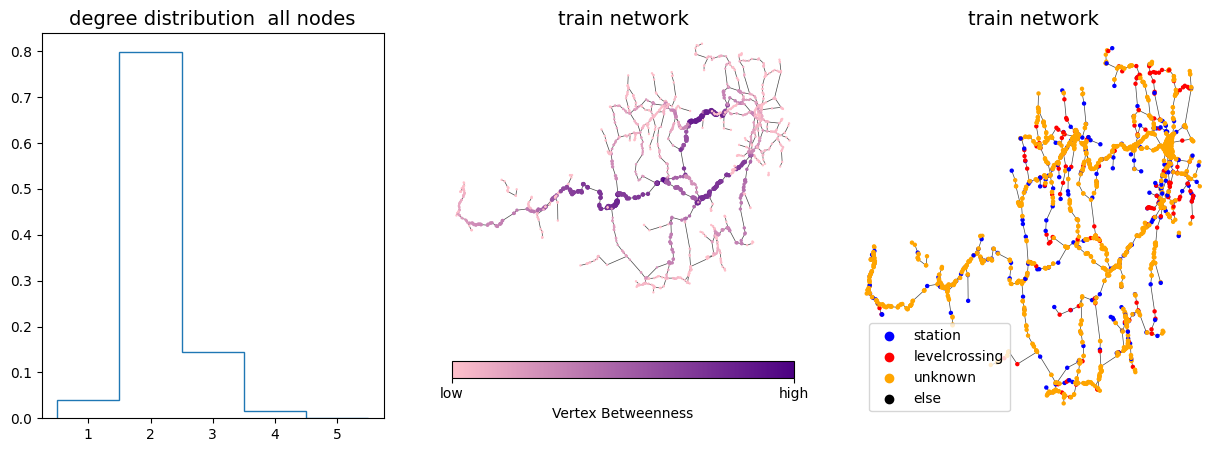

In [3]:



def get_info_country(land_code):
    edges = pd.read_csv('output/edges_'+land_code+'.csv')
    nodes = pd.read_csv(('output/nodes_'+land_code+'.csv'))

    g = ig.Graph.DataFrame(edges, directed=False, vertices=nodes)
    
    g.vs['nodeLabel'] = nodes['nodeLabel']
    degree_full = g.degree()
    stations = g.vs.select(nodeLabel='station')
    degree_station = stations.degree()


    lay = list(zip(g.vs['longetude'],np.array(g.vs['latitude'])))
    fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))


    counts, bins = np.histogram(degree_full, bins = np.arange(0,max(degree_full)+1)+0.5, density = True)
    ax[0].stairs(counts, bins)
    ax[0].set_title('degree distribution  all nodes', fontsize = 14)


    ax[1].set_title('harmonic centrality', fontsize = 14)
    ax[1].set_title('train network', fontsize = 14)
    ax[1].set_xlim([np.min(g.vs['longetude'])-0.1,np.max(g.vs['longetude']) + 0.1])
    ax[1].set_ylim([np.min(g.vs['latitude'])-0.1,np.max(g.vs['latitude'])+0.1])


    vertex_betweenness = g.betweenness()
    # Define the gradient palette from pink to blue
    scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
    cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "indigo"])
    g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]
    g.vs["size"]  = ig.rescale(vertex_betweenness, (1, 5))
    norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
    cbar = plt.colorbar(norm1, ax=ax[1], orientation="horizontal", label='Vertex Betweenness')
    cbar.set_ticks([0, np.max(vertex_betweenness)])
    cbar.set_ticklabels(['low', 'high'])

    ig.plot(g, 
    layout = lay,
    vertex_size= g.vs['size'],
    vertex_color = g.vs['color'],
    vertex_frame_color = g.vs['color'],
     edge_width = 0.5, target =ax[1])


    vertex_color = list(g.vs['nodeLabel'])
    vertex_color = ['blue' if item == 'station' else 'red' if item == 'levelcrossing' else 'orange' if item == 'unknown' else 'black' for item in vertex_color]
    vertex_size = g.vs['nodeLabel']
    vertex_size = [3 if item == 'station' else 3 for item in vertex_size]

    ax[2].set_yticks([])
    ax[2].set_xticks([])
    ax[2].scatter([],[], color = "blue", label = 'station')
    ax[2].scatter([],[], color = "red", label = 'levelcrossing')
    ax[2].scatter([],[], color = "orange", label = 'unknown')
    ax[2].scatter([],[], color = "black", label = 'else')

    ax[2].set_title('train network', fontsize = 14)
    ax[2].set_xlim([np.min(g.vs['longetude'])-0.1,np.max(g.vs['longetude']) + 0.1])
    ax[2].set_ylim([np.min(g.vs['latitude'])-0.1,np.max(g.vs['latitude'])+0.1])
    

    ig.plot(g, 
    layout = lay,
    vertex_size= vertex_size,
    vertex_frame_color = list(vertex_color), vertex_color = list(vertex_color), edge_width = 0.5, target =ax[2])

    plt.legend(loc = 'lower left')
    save_results_to = 'output/'
    plt.savefig(save_results_to + '45_1.png', dpi = 300)







get_info_country('AT')